First pre-optimization image:


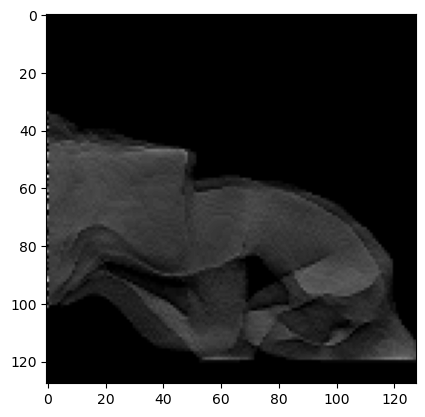

In [27]:
import numpy as np
import os
import sys
import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
from PIL import Image

# Set the paths to the image folders
pre_optimization_folder = 'D:/archive/members/mark/ML_input/'
save_path = 'D:/archive/members/mark/MLResults/'
modelFile = "./model_128x128_200.pth"
optionalPlot = False
optionalSave = True
file_index = 56 
batch_size = 90

start_time = time.time()

# Function to load grayscale images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
    return images

# Load pre-optimization grayscale images
pre_optimization_images = load_images_from_folder(pre_optimization_folder)

# Convert image lists to numpy arrays
pre_optimization_images = np.array(pre_optimization_images)

# Normalize the image data
pre_optimization_images = pre_optimization_images / 255.0

# Convert numpy arrays to PyTorch tensors
x_train = torch.from_numpy(pre_optimization_images).unsqueeze(1).float()


print("First pre-optimization image:")
plt.imshow(pre_optimization_images[0], cmap='gray')
plt.show()


In [28]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.middle_conv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
        )

        self.decoder = nn.Sequential(
            
            nn.Conv2d(192, 64, kernel_size=3, padding=1),  # Concatenating feature maps from the encoder
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x):
        encoder_output1 = self.encoder(x)
        encoder_output2 = self.middle_conv(encoder_output1)
        decoder_input = torch.cat([encoder_output2, encoder_output1], dim=1)  # Concatenate feature maps
        decoder_output = self.decoder(decoder_input)
        return decoder_output
  
    
model = UNet()
model.load_state_dict(torch.load(modelFile))
model.eval()



UNet(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (middle_conv): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): GELU(approximate='none')
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): GELU(approximate='none')
    (5): Upsample(scale_factor=2.0, mode=bilinear)
  )
  (decoder): Sequential(
    (0): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [29]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import time
import os
import sys
import cv2

device_count = torch.cuda.device_count()
if device_count > 0:
    print("Available GPUs:")
    for i in range(device_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs available. PyTorch is using CPU.")

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    model = model.to(device)
    print("PyTorch is using GPU.")
else:
    print("PyTorch is using CPU.")

# Convert the data to the appropriate device
x_train = x_train.to(device)

# dataset = TensorDataset(x_train)

# # Create PyTorch DataLoaders for training and validation
# dataloader = DataLoader(dataset = dataset, batch_size=1, shuffle=False)



Available GPUs:
GPU 0: NVIDIA RTX A5000
PyTorch is using GPU.


In [30]:
# import matplotlib.pyplot as plt

# example_inputs = []
# example_outputs = []

# count = 0
# # Iterate through batches from the validation dataloader
# for batch in dataloader:
#     print("Batch No. " + str(count))
#     batch_inputs = batch[0]
#     batch_inputs = batch_inputs.to(device)

#     # Forward pass through the model
#     with torch.no_grad():
#         batch_outputs = model(batch_inputs)

#     # Convert the tensors to numpy arrays
#     batch_inputs = batch_inputs.cpu().numpy()
#     batch_outputs = batch_outputs.cpu().numpy()


#     # Reshape the example inputs and outputs if needed
#     # (Assuming the inputs and outputs have shape (batch_size, channels, height, width))
#     batch_inputs = batch_inputs.transpose(0, 2, 3, 1)
#     batch_outputs = batch_outputs.transpose(0, 2, 3, 1)

#     #Create the final list containing the inputs and outputs for all files instead instead of just one batch
#     example_inputs.append(batch_inputs)
#     example_outputs.append(batch_outputs)
#     count+=1


# # Plot the example inputs, targets, and outputs

# #Optionally plots the output for a single file index:
# #file_index should be divisible by (360/batch_size)

# if optionalPlot:
#     for factor in range ((int)(360/batch_size)):
#         for i in range ((int)(batch_size/5)):
#             plt.figure(figsize=(16, 7))
#             for j in range(5):
#                 plt.subplot(2, 5, j+1)
#                 plt.imshow(example_inputs[file_index+factor][i*5+j])
#                 plt.title('Input')
#                 plt.axis('off')

#                 plt.subplot(2, 5, 5 + j + 1)
#                 plt.imshow(example_outputs[file_index+factor][i*5+j])
#                 plt.title('Output')
#                 plt.axis('off')
#             plt.tight_layout()
#             plt.show()

# end_time = time.time()
# print(end_time-start_time)
# # print(example_outputs[0])

In [31]:


# if optionalSave:
#     for k in range(len(example_outputs)):
#         image = example_outputs[k]
        
#         # Normalize the pixel values to the range [0, 255]
#         image_normalized = (image - image.min()) * (255.0 / (image.max() - image.min()))

#         # Convert to integer type and create the image
#         image = image.astype(np.uint8)
#         im = Image.fromarray(image)

#         im.save(save_path, subsampling=0, quality=100)
#         # print(f"Saving image {str(k).zfill(4)}/{str(len(b[0])).zfill(4)}")


In [32]:

# Create a directory to save the output images
if optionalSave and not os.path.exists(save_path):
    os.makedirs(save_path)

# Function to save grayscale images
def save_images(images, path, prefix="output_", file_extension=".png"):
    for i, image in enumerate(images):
        filename = os.path.join(path, f"{prefix}{i:04d}{file_extension}")
        cv2.imwrite(filename, (image * 255).astype(np.uint8))

# Create an empty list to store the output images
output_images = []

# Iterate through your input images in batches
for i in range(0, len(x_train), batch_size):
    batch = x_train[i:i + batch_size]
    
    # Make predictions using the U-Net model
    with torch.no_grad():
        predicted_images = model(batch)

    # Convert the predicted images back to NumPy arrays
    predicted_images = predicted_images.squeeze(1).cpu().numpy()

    # Append the predicted images to the list
    output_images.extend(predicted_images)

# Save the output images
if optionalSave:
    save_images(output_images, save_path)

# Optionally, plot the first output image
if optionalPlot:
    print("First output image:")
    plt.imshow(output_images[0], cmap='gray')
    plt.show()

# Calculate and print the time taken
end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")


Total time taken: 0.76 seconds
